Possibly Broken???

In [26]:
import numpy as np
import numpy.ma as ma

from mpl_toolkits import mplot3d
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["text.usetex"] = False
from matplotlib import cm, colors
from matplotlib.patches import Ellipse
import matplotlib as mpl
from numpy import arange,array,ones,linalg
from scipy.optimize import minimize
from scipy import ndimage
from scipy import stats

from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.wcs import WCS
from astropy.utils.data import get_pkg_data_filename
from astropy.visualization.wcsaxes import SphericalCircle
from astropy.nddata import bitmask
from astropy.nddata.bitmask import BitFlagNameMap
import math
from tqdm import tqdm

import copy

from scipy.ndimage import gaussian_filter1d

In [27]:
import os
current_directory = os.getcwd()
print(current_directory)

/global/u1/j/jlargett/DESI_SGA/Morphology


In [28]:
SGA_Param_Data = Table.read('SGA_Asym_Data.fits')
SGA_Param_Data

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,COLOR G-Z,COLOR G-R,COLOR R-Z,R50_R,m(r50)_G,m(r50)_Z,m(r50)_R,GRADIENT_G-Z,GRADIENT_G-R,GRADIENT_R-Z,C_INDEX_G_r50_r90,C_INDEX_R_r50_r90,C_INDEX_Z_r50_r90,r90_R,r50_G,r90_G,r50_Z,r90_Z,GINI_G,GINI_R,GINI_Z,Asymmetry_G,Asymmetry_R,Asymmetry_Z
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64
2,SGA-2020 2,PGC1283207,1283207,228.3770865,5.4232017,S?,152.2,0.36307806,0.724436,0.03463229,23.40448,16.976,False,LEDA-20181114,0,PGC1283207,1,True,228.3770865,5.4232017,0.36307806,2283p055,228.3770803831908,5.423191398593787,0.49470574,SB26,158.20142,0.545691,228.37700918822188,5.4232652570544015,10.897086,3.3509698,3.1147978,3.240862,5.902337,6.9126143,7.941369,8.997992,10.073601,11.199986,12.391357,13.561038,14.841172,16.966799,16.108246,15.486356,16.879545,16.024958,15.400715,16.818878,15.967034,15.341793,16.776297,15.925804,15.300776,16.746685,15.897334,15.272053,16.725166,15.876816,15.2521105,16.708357,15.862035,15.237181,16.696539,15.851936,15.226998,16.689613,15.844313,15.21976,0.013392451,0.02354,0.021872982,0.01736985,0.024445537,0.039866067,0.05026544,0.08455789,0.122911856,0.005682776,0.0054258136,0.0049038026,0.005588406,0.005323561,0.0047632363,0.00543534,0.005177031,0.0046343105,0.0053025587,0.005040888,0.0045181247,0.005206092,0.0049438984,0.0044374703,0.0051483097,0.0048758644,0.0043834248,0.0051032505,0.0048264163,0.004344

In [29]:
# Path to a random image in NERSC
f1 = math.trunc(SGA_Param_Data['RA'][1])
f2 = math.trunc((1000*SGA_Param_Data['RA'][1]))
f3 = math.trunc((100000*SGA_Param_Data['RA'][1]))
f4 = 'm' if SGA_Param_Data['DEC'][1] < 0 else 'p'
f5 = abs(math.trunc((100000*SGA_Param_Data['DEC'][1])))
path = '/pscratch/sd/b/barnerg/SGA2024/cutouts/{:03d}/{:06d}/{:08d}{}{:07d}.fits'.format(f1,f2,f3,f4,f5)
fits_file = fits.open(path)
image = fits_file[0].data
bit_mask = fits_file[1].data

In [30]:
print(f"Image Shape: {image.shape}")
print(f"Bitmask Shape: {bit_mask.shape}")

Image Shape: (3, 227, 227)
Bitmask Shape: (227, 227)


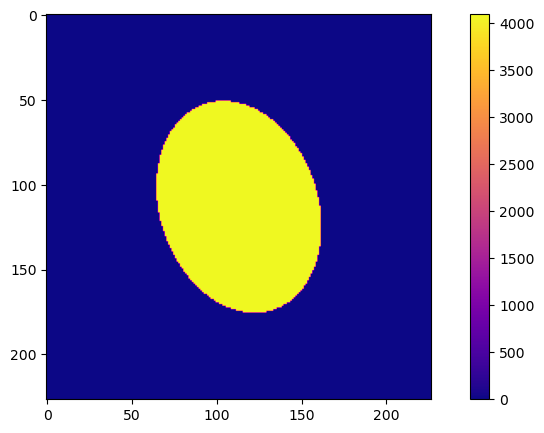

In [31]:
# Showing image 
plt.rcParams["figure.figsize"] = (10, 5)
plt.imshow(bit_mask, cmap='plasma')
plt.colorbar()

In [32]:
# Reshape the data
if image.shape[0] == 3:
    image_data = np.transpose(image, (1, 2, 0))
print(f"Image Shape: {image_data.shape}")

Image Shape: (227, 227, 3)


In [33]:
fits_file.close()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


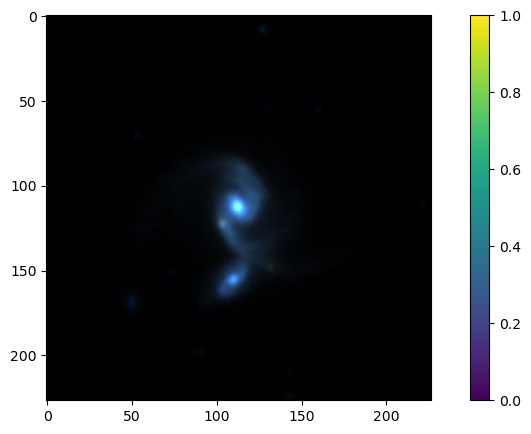

In [34]:
# Showing normal image 
plt.rcParams["figure.figsize"] = (10, 5)
plt.imshow(image_data)
plt.colorbar()

In [35]:
# Bits in the dict
MASKBITS = dict(
    NPRIMARY   = 0x1,   # not PRIMARY
    BRIGHT     = 0x2,
    SATUR_G    = 0x4,
    SATUR_R    = 0x8,
    SATUR_Z    = 0x10,
    ALLMASK_G  = 0x20,
    ALLMASK_R  = 0x40,
    ALLMASK_Z  = 0x80,
    WISEM1     = 0x100, # WISE masked
    WISEM2     = 0x200,
    BAILOUT    = 0x400, # bailed out of processing
    MEDIUM     = 0x800, # medium-bright star
    GALAXY     = 0x1000, # SGA large galaxy
    CLUSTER    = 0x2000, # Cluster catalog source
    SATUR_I    = 0x4000,
    ALLMASK_I  = 0x8000,
    SUB_BLOB   = 0x10000,
)

In [36]:
# Generate bitmask to apply to image
condition = bit_mask & MASKBITS['GALAXY'] != 0
mask_ = condition.astype(int)

In [37]:
# Generate bitmask to apply to image
condition2 = mask_ & (MASKBITS['BRIGHT'] | MASKBITS['SATUR_G'] | MASKBITS['SATUR_R'] | MASKBITS['SATUR_Z'] | MASKBITS['WISEM1'] | MASKBITS['WISEM2']) != 0
mask_2 = mask_ & ~condition2

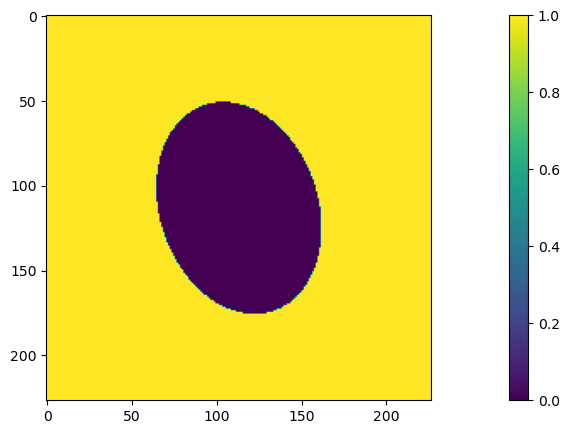

In [38]:
# Showing mask
plt.rcParams["figure.figsize"] = (20, 5)
plt.imshow(~(mask_2.astype(bool)))
plt.colorbar();

In [39]:
mask = np.dstack([mask_2.astype(bool), mask_2.astype(bool), mask_2.astype(bool)])
print(f"Mask Shape: {mask.shape}")

Mask Shape: (227, 227, 3)


In [40]:
mimage_data = ma.array(image_data, mask=~mask)
print(f"Masked Image Shape: {mimage_data.shape}")

Masked Image Shape: (227, 227, 3)


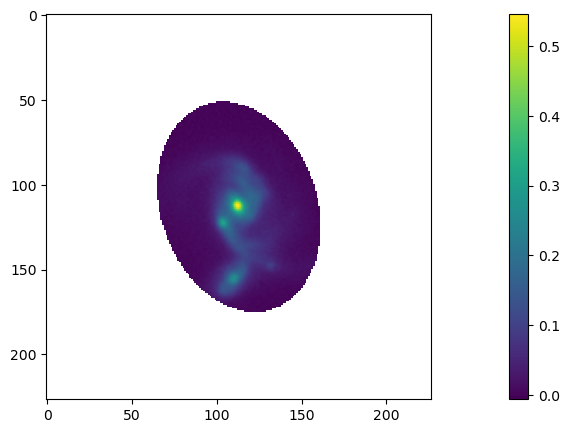

In [41]:
# showing masked image
plt.rcParams["figure.figsize"] = (20, 5)
plt.imshow(mimage_data[:,:,0])
plt.colorbar();

In [42]:
# color images
mg_image = ma.array(image_data[:,:,0], mask=~mask_2.astype(bool))
mr_image = ma.array(image_data[:,:,1], mask=~mask_2.astype(bool))
mz_image = ma.array(image_data[:,:,2], mask=~mask_2.astype(bool))

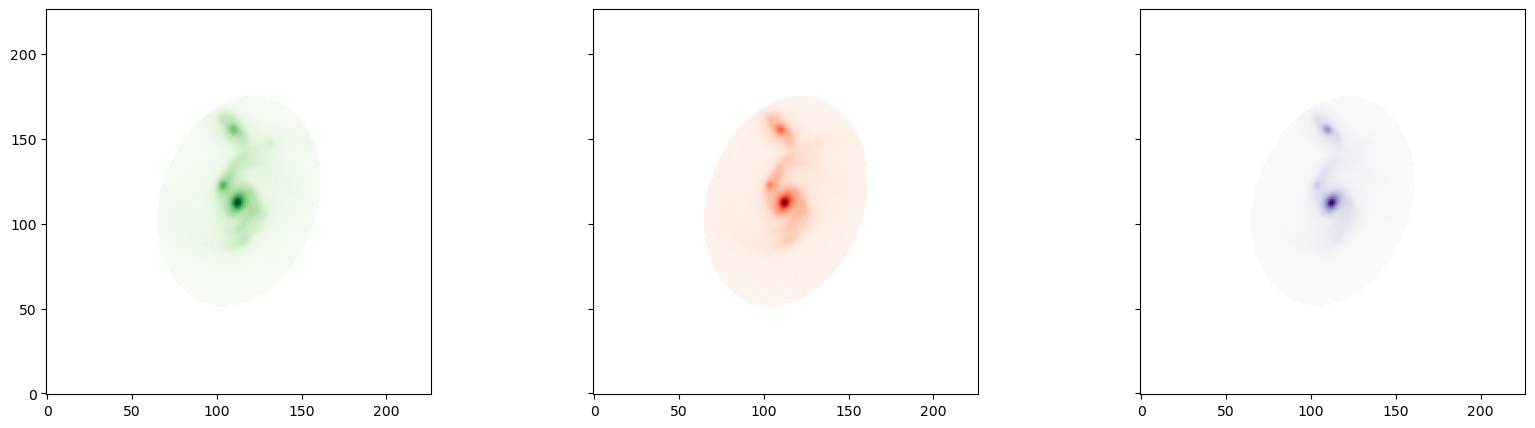

In [43]:
plt.figure()
ax1=plt.subplot(131)
plt.imshow(mg_image, origin='lower', cmap='Greens')
plt.subplot(132, sharey=ax1)
plt.imshow(mr_image, origin='lower', cmap='Reds')
plt.tick_params('y', labelleft=False)
plt.subplot(133, sharey=ax1)
plt.imshow(mz_image, origin='lower', cmap='Purples')
plt.tick_params('y', labelleft=False);

Second Order Moment of Light Parameter

In [44]:
print(f"Shape of image_data: {image_data.shape}")
print(f"Shape of mg_image: {mg_image.shape}")
print(f"Shape of mimage_data: {mimage_data.shape}")
print(type(mg_image))

Shape of image_data: (227, 227, 3)
Shape of mg_image: (227, 227)
Shape of mimage_data: (227, 227, 3)
<class 'numpy.ma.core.MaskedArray'>


In [45]:
# extract the image shape and coordinates for g, r, and z
# x contains the column coordinates and y the row coordinates
rowsg, colsg = mg_image.shape
yg, xg = np.mgrid[0:rowsg, 0:colsg]
squared_distanceg = xg**2 + yg**2

rowsr, colsr = mr_image.shape
yr, xr = np.mgrid[0:rowsr, 0:colsr]
squared_distancer = xr**2 + yr**2

rowsz, colsz = mz_image.shape
yz, xz = np.mgrid[0:rowsz, 0:colsz]
squared_distancez = xz**2 + yz**2

print(xg)
print(yg)
print(xr)
print(yr)
print(xz)
print(yz)
print(squared_distanceg)
print(squared_distancer)
print(squared_distancez)

[[  0   1   2 ... 224 225 226]
 [  0   1   2 ... 224 225 226]
 [  0   1   2 ... 224 225 226]
 ...
 [  0   1   2 ... 224 225 226]
 [  0   1   2 ... 224 225 226]
 [  0   1   2 ... 224 225 226]]
[[  0   0   0 ...   0   0   0]
 [  1   1   1 ...   1   1   1]
 [  2   2   2 ...   2   2   2]
 ...
 [224 224 224 ... 224 224 224]
 [225 225 225 ... 225 225 225]
 [226 226 226 ... 226 226 226]]
[[  0   1   2 ... 224 225 226]
 [  0   1   2 ... 224 225 226]
 [  0   1   2 ... 224 225 226]
 ...
 [  0   1   2 ... 224 225 226]
 [  0   1   2 ... 224 225 226]
 [  0   1   2 ... 224 225 226]]
[[  0   0   0 ...   0   0   0]
 [  1   1   1 ...   1   1   1]
 [  2   2   2 ...   2   2   2]
 ...
 [224 224 224 ... 224 224 224]
 [225 225 225 ... 225 225 225]
 [226 226 226 ... 226 226 226]]
[[  0   1   2 ... 224 225 226]
 [  0   1   2 ... 224 225 226]
 [  0   1   2 ... 224 225 226]
 ...
 [  0   1   2 ... 224 225 226]
 [  0   1   2 ... 224 225 226]
 [  0   1   2 ... 224 225 226]]
[[  0   0   0 ...   0   0   0]
 [  1   1

Current Working Calculation in these two cells below :)

In [46]:
# Assuming mg_image is your galaxy image
rowsg, colsg = mg_image.shape
rowsr, colsr = mr_image.shape
rowsz, colsz = mz_image.shape

# Calculate the center coordinates
center_rowg = rowsg // 2
center_colg = colsg // 2

center_rowr = rowsr // 2
center_colr = colsr // 2

center_rowz = rowsz // 2
center_colz = colsz // 2

# Create meshgrid with origin at the center
yg, xg = np.mgrid[-center_rowg:center_rowg, -center_colg:center_colg]
yr, xr = np.mgrid[-center_rowr:center_rowr, -center_colr:center_colr]
yz, xz = np.mgrid[-center_rowz:center_rowz, -center_colz:center_colz]

squared_distanceg = xg**2 + yg**2
squared_distancer = xr**2 + yr**2
squared_distancez = xz**2 + yz**2

print(squared_distanceg)
print(squared_distancer)
print(squared_distancez)

[[25538 25313 25090 ... 24869 25090 25313]
 [25313 25088 24865 ... 24644 24865 25088]
 [25090 24865 24642 ... 24421 24642 24865]
 ...
 [24869 24644 24421 ... 24200 24421 24644]
 [25090 24865 24642 ... 24421 24642 24865]
 [25313 25088 24865 ... 24644 24865 25088]]
[[25538 25313 25090 ... 24869 25090 25313]
 [25313 25088 24865 ... 24644 24865 25088]
 [25090 24865 24642 ... 24421 24642 24865]
 ...
 [24869 24644 24421 ... 24200 24421 24644]
 [25090 24865 24642 ... 24421 24642 24865]
 [25313 25088 24865 ... 24644 24865 25088]]
[[25538 25313 25090 ... 24869 25090 25313]
 [25313 25088 24865 ... 24644 24865 25088]
 [25090 24865 24642 ... 24421 24642 24865]
 ...
 [24869 24644 24421 ... 24200 24421 24644]
 [25090 24865 24642 ... 24421 24642 24865]
 [25313 25088 24865 ... 24644 24865 25088]]


In [47]:
# Calculate the total second-order moments for each band
moment_g = np.sum(mg_image * squared_distanceg)
moment_r = np.sum(mr_image * squared_distancer)
moment_z = np.sum(mz_image * squared_distancez)

print("Mtot for g band:", moment_g)
print("Mtot for r band:", moment_r)
print("Mtot for z band:", moment_z)

# flatten the images
flattened_g = np.ravel(mg_image)
flattened_r = np.ravel(mr_image)
flattened_z = np.ravel(mz_image)

# sort the indices by assosiated intensity pixel, greatest to lowest intensity
sorted_pix_g = np.argsort(flattened_g)[::-1]
sorted_pix_r = np.argsort(flattened_r)[::-1]
sorted_pix_z = np.argsort(flattened_z)[::-1]

# make a list of intensity values greatest to lowest
intlistg = flattened_g[sorted_pix_g]
intlistr = flattened_r[sorted_pix_r]
intlistz = flattened_z[sorted_pix_z]

# make a list of the squared distances sorted with the associated intensity
ordered_squared_distancesg = squared_distanceg.flatten()[sorted_pix_g]
ordered_squared_distancesr = squared_distancer.flatten()[sorted_pix_r]
ordered_squared_distancesz = squared_distancez.flatten()[sorted_pix_z]

# calculate the summation of the sorted pixel values using squared distances
cumulative_sum_g = np.cumsum(intlistg * ordered_squared_distancesg)
cumulative_sum_r = np.cumsum(intlistr * ordered_squared_distancesgr)
cumulative_sum_z = np.cumsum(intlistz * ordered_squared_distancesz)

print("Cumulative Sum G:", cumulative_sum_g)
print("Cumulative Sum R:", cumulative_sum_r)
print("Cumulative Sum Z:", cumulative_sum_z)

# find the index where the sum reaches 20% of the total second-order moment
twenty_percent_index_g = np.argmax(cumulative_sum_g >= 0.2 * moment_g)
twenty_percent_index_r = np.argmax(cumulative_sum_r >= 0.2 * moment_r)
twenty_percent_index_z = np.argmax(cumulative_sum_z >= 0.2 * moment_z)

print(twenty_percent_index_g, twenty_percent_index_r, twenty_percent_index_z)

# calculate the 
mig = np.sum(intlistg[:twenty_percent_index_g + 1] * ordered_squared_distancesg[:twenty_percent_index_g + 1])
mir = np.sum(intlistr[:twenty_percent_index_r + 1] * ordered_squared_distancesr[:twenty_percent_index_r + 1])
miz = np.sum(intlistz[:twenty_percent_index_z + 1] * ordered_squared_distancesz[:twenty_percent_index_z + 1])
             
# Calculate the normalized M20 moment for each band
m20_g = np.log10(mig / moment_g)
m20_r = np.log10(mir / moment_r)
m20_z = np.log10(miz / moment_z)

print("M20 for g band:", m20_g)
print("M20 for r band:", m20_r)
print("M20 for z band:", m20_z)

ValueError: operands could not be broadcast together with shapes (227,227) (226,226) 

In [48]:
plt.plot(flattened_g)
plt.plot(flattened_g[sorted_pix_g])
print("Sorted Indices:", sorted_pix_g)
print("Sorted Values:", flattened_g[sorted_pix_g])

NameError: name 'flattened_g' is not defined

Sorted Indices: [3 1 4 0 2]
Sorted Values: [9 7 5 4 2]


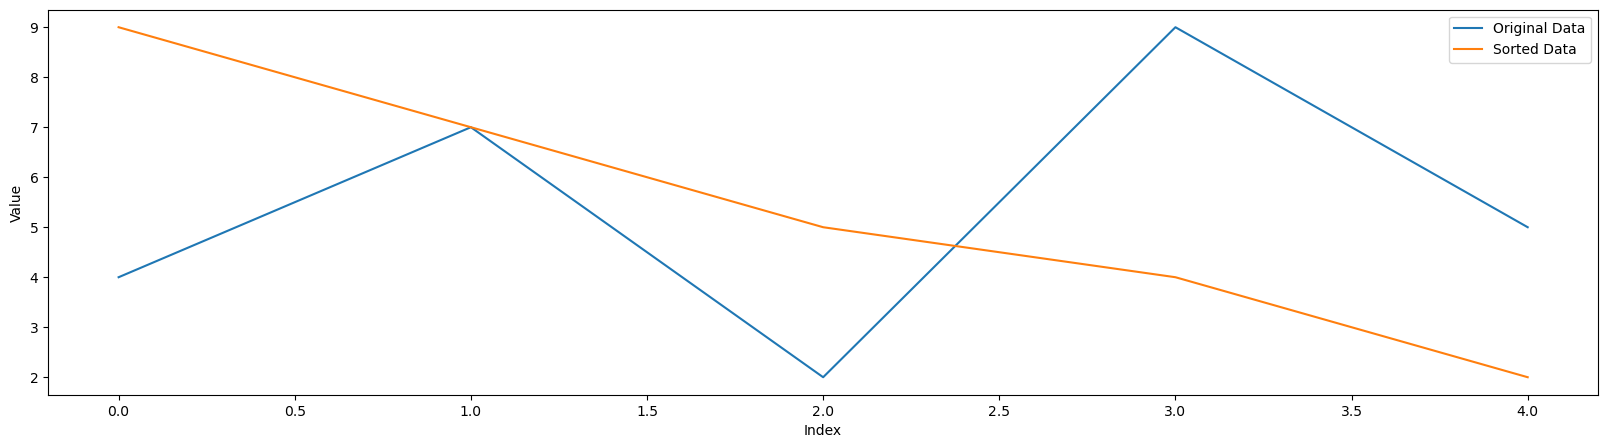

In [95]:
import numpy as np
import matplotlib.pyplot as plt

flattened_g = np.array([4, 7, 2, 9, 5])
sorted_pix_g = np.argsort(flattened_g)[::-1]
print("Sorted Indices:", sorted_pix_g)
print("Sorted Values:", flattened_g[sorted_pix_g])

plt.plot(flattened_g, label='Original Data')
plt.plot(flattened_g[sorted_pix_g], label='Sorted Data')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.show()

In [87]:
def calculate_second_order_moment(image):
    # extract the image shape and coordinates
    rows, cols = image.shape
    y, x = np.mgrid[0:rows, 0:cols]

    # computes the squared distance from each pixel to the origin (0,0)
    squared_distance = x**2 + y**2

    # calculate the second-order moment
    second_order_moment = np.sum(image * squared_distance)

    return second_order_moment

# Calculate the second-order moment for each band
moment_g = calculate_second_order_moment(mg_image)
moment_r = calculate_second_order_moment(mr_image)
moment_z = calculate_second_order_moment(mz_image)

print("Second-order moment for g band:", moment_g)
print("Second-order moment for r band:", moment_r)
print("Second-order moment for z band:", moment_z)

Second-order moment for g band: 8972494.342476564
Second-order moment for r band: 20866761.52389327
Second-order moment for z band: 32390663.448511504


In [29]:
def calculate_normalized_m20(flattened, sorted_indices, squared_distance, total_moment):
    # calculate the cumulative sum of the sorted pixel values using squared distances
    cumulative_sum = np.cumsum(flattened[sorted_indices] * squared_distance.flatten()[sorted_indices])

    # Find the index where the cumulative sum reaches 20% of the total second-order moment
    twenty_percent_index = np.argmax(cumulative_sum >= 0.2 * total_moment)

    # Calculate the normalized M20 moment
    normalized_m20 = np.log10(np.sum(flattened[sorted_indices[:twenty_percent_index + 1]] * squared_distance.flatten()[sorted_indices[:twenty_percent_index + 1]]) / (total_moment))

    return normalized_m20

# Calculate the normalized M20 moment for each band
normalized_m20_g = calculate_normalized_m20(flattened_g, sorted_indices_g, squared_distanceg, moment_g)
normalized_m20_r = calculate_normalized_m20(flattened_r, sorted_indices_r, squared_distancer, moment_r)
normalized_m20_z = calculate_normalized_m20(flattened_z, sorted_indices_z, squared_distancez, moment_z)

print("M20 for g band:", normalized_m20_g)
print("M20 for r band:", normalized_m20_r)
print("M20 for z band:", normalized_m20_z)

NameError: name 'sorted_indices_g' is not defined

In [38]:
from scipy.ndimage import zoom
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Create a list to store indices of processed galaxies
processed_galaxies = []
no_bitmask = []
no_image_path = []
image_shape_unknown = []

# Create a deep copy of the original catalog
SGA_Param_Data_Copy = copy.deepcopy(SGA_Param_Data)

n_galaxies = len(SGA_Param_Data)


SGA_Param_Data_Copy['M20_G'] = np.NaN * np.ones(n_galaxies)
SGA_Param_Data_Copy['M20_R'] = np.NaN * np.ones(n_galaxies)
SGA_Param_Data_Copy['M20_Z'] = np.NaN * np.ones(n_galaxies)

galaxy_range = range(0, 5)

for i in tqdm(galaxy_range, desc="Processing Galaxies", unit="galaxy", leave=True):
    f1 = math.trunc(SGA_Param_Data_Copy['RA'][i])
    f2 = math.trunc((1000*SGA_Param_Data_Copy['RA'][i]))
    f3 = math.trunc((100000*SGA_Param_Data_Copy['RA'][i]))
    f4 = 'm' if SGA_Param_Data_Copy['DEC'][i] < 0 else 'p'
    f5 = abs(math.trunc((100000*SGA_Param_Data_Copy['DEC'][i])))
    path = '/pscratch/sd/b/barnerg/SGA2024/cutouts/{:03d}/{:06d}/{:08d}{}{:07d}.fits'.format(f1,f2,f3,f4,f5)
    
    if os.path.exists(path):
        fits_file = fits.open(path, ignore_missing_simple=True, ignore_missing_end=True)
        
        try:
            fits_file[1].data
        except:
            no_bitmask.append(path)
            var_exists = False
        else:
            var_exists = True
            
        if var_exists: 
            image = fits_file[0].data
            bit_mask = fits_file[1].data
            fits_file.close()
    
            print("image shape:", image.shape, "bitmask shape:", bit_mask.shape)
    
            # reshape the data
            # checking to see if the galaxy has 3 color channels
            if image.shape[0] == 3:
                # the tuple swaps the 1st and 3rd dimensions, resulting in a new array, and assigns this array to the variable image_data
                image_data = np.transpose(image, (1, 2, 0))
                print("image_data shape:", image_data.shape)
                fits_file.close()

                # generate bitmask to apply to image
                condition = bit_mask & MASKBITS['GALAXY'] != 0
                mask_int = condition.astype(int)
                print("mask_int:", mask_int)
                
                # filtering out specific pixels in an image based on these additional conditions.
                condition2 = mask_int & (MASKBITS['BRIGHT'] | MASKBITS['SATUR_G'] | MASKBITS['SATUR_R'] | MASKBITS['SATUR_Z'] | MASKBITS['WISEM1'] | MASKBITS['WISEM2']) != 0
                mask_2 = mask_int & ~condition2

                # make the mask (318, 318, 3), where the third dimension represents the same 2D mask array duplicated three times
                mask = np.dstack([mask_2.astype(bool), mask_2.astype(bool), mask_2.astype(bool)])
                mimage_data = ma.array(image_data, mask=~mask)
                print("mask shape:", mask.shape)
                print("mimage_data shape:", mimage_data.shape)
                
                # mask each color
                mg_image = ma.array(image_data[:,:,0], mask=~mask_2.astype(bool))
                mr_image = ma.array(image_data[:,:,1], mask=~mask_2.astype(bool))
                mz_image = ma.array(image_data[:,:,2], mask=~mask_2.astype(bool))

                # calculate M20 parameter

                # Calculate the second-order moment for each band
                moment_g = calculate_second_order_moment(mg_image)
                moment_r = calculate_second_order_moment(mr_image)
                moment_z = calculate_second_order_moment(mz_image)

                # Calculate the normalized M20 moment for each band
                normalized_m20_g = calculate_normalized_m20(flattened_g, sorted_indices_g, squared_distanceg, moment_g)
                normalized_m20_r = calculate_normalized_m20(flattened_r, sorted_indices_r, squared_distancer, moment_r)
                normalized_m20_z = calculate_normalized_m20(flattened_z, sorted_indices_z, squared_distancez, moment_z)

                # Append asymmetry values to the new columns in the copied catalog
                SGA_Param_Data_Copy[i]['M20_G'] = normalized_m20_g
                SGA_Param_Data_Copy[i]['M20_R'] = normalized_m20_r
                SGA_Param_Data_Copy[i]['M20_Z'] = normalized_m20_z

                # Append the index of the processed galaxy to the list
                processed_galaxies.append(i)

                print("Galaxy processed!", i)
        
            else:
                image_shape_unknown.append(path)
    else: 
        no_image_path.append(path)

Processing Galaxies: 100%|██████████| 5/5 [00:00<00:00, 83.67galaxy/s]

image shape: (3, 213, 213) bitmask shape: (213, 213)
image_data shape: (213, 213, 3)
mask_int: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
mask shape: (213, 213, 3)
mimage_data shape: (213, 213, 3)
Galaxy processed! 0
image shape: (3, 227, 227) bitmask shape: (227, 227)
image_data shape: (227, 227, 3)
mask_int: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
mask shape: (227, 227, 3)
mimage_data shape: (227, 227, 3)
Galaxy processed! 1
image shape: (3, 185, 185) bitmask shape: (185, 185)
image_data shape: (185, 185, 3)
mask_int: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
mask shape: (185, 185, 3)
mimage_data shape: (185, 185, 3)
Galaxy processed! 2
image shape: (3, 303, 303) bitmask shape: (303, 303)
image_data shape: (303, 303, 3)
mask_int: [[0 0 0 ... 0 0 0]
 [0 

In [34]:
from scipy.ndimage import zoom
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Create a list to store indices of processed galaxies
processed_galaxies = []
no_bitmask = []
no_image_path = []
image_shape_unknown = []

# Create a deep copy of the original catalog
SGA_Param_Data_Copy = copy.deepcopy(SGA_Param_Data)

n_galaxies = len(SGA_Param_Data)

SGA_Param_Data_Copy['M20_G'] = np.NaN * np.ones(n_galaxies)
SGA_Param_Data_Copy['M20_R'] = np.NaN * np.ones(n_galaxies)
SGA_Param_Data_Copy['M20_Z'] = np.NaN * np.ones(n_galaxies)

galaxy_range = range(0, 20000)

for i in tqdm(galaxy_range, desc="Processing Galaxies", unit="galaxy", leave=True):
    f1 = math.trunc(SGA_Param_Data_Copy['RA'][i])
    f2 = math.trunc((1000*SGA_Param_Data_Copy['RA'][i]))
    f3 = math.trunc((100000*SGA_Param_Data_Copy['RA'][i]))
    f4 = 'm' if SGA_Param_Data_Copy['DEC'][i] < 0 else 'p'
    f5 = abs(math.trunc((100000*SGA_Param_Data_Copy['DEC'][i])))
    path = '/pscratch/sd/b/barnerg/SGA2024/cutouts/{:03d}/{:06d}/{:08d}{}{:07d}.fits'.format(f1,f2,f3,f4,f5)
    
    if os.path.exists(path):
        fits_file = fits.open(path, ignore_missing_simple=True, ignore_missing_end=True)
        
        try:
            fits_file[1].data
        except:
            no_bitmask.append(path)
            var_exists = False
        else:
            var_exists = True
            
        if var_exists: 
            image = fits_file[0].data
            bit_mask = fits_file[1].data
            fits_file.close()
    
            #print("image shape:", image.shape, "bitmask shape:", bit_mask.shape)
    
            # reshape the data
            # checking to see if the galaxy has 3 color channels
            if image.shape[0] == 3:
                # the tuple swaps the 1st and 3rd dimensions, resulting in a new array, and assigns this array to the variable image_data
                image_data = np.transpose(image, (1, 2, 0))
                #print("image_data shape:", image_data.shape)
                fits_file.close()

                # generate bitmask to apply to image
                condition = bit_mask & MASKBITS['GALAXY'] != 0
                mask_int = condition.astype(int)
                #print("mask_int:", mask_int)
                
                # filtering out specific pixels in an image based on these additional conditions
                condition2 = mask_int & (MASKBITS['BRIGHT'] | MASKBITS['SATUR_G'] | MASKBITS['SATUR_R'] | MASKBITS['SATUR_Z'] | MASKBITS['WISEM1'] | MASKBITS['WISEM2']) != 0
                mask_2 = mask_int & ~condition2

                # make the mask (318, 318, 3), where the third dimension represents the same 2D mask array duplicated three times
                mask = np.dstack([mask_2.astype(bool), mask_2.astype(bool), mask_2.astype(bool)])
                mimage_data = ma.array(image_data, mask=~mask)
                #print("mask shape:", mask.shape)
                #print("mimage_data shape:", mimage_data.shape)
                
                # mask each color
                mg_image = ma.array(image_data[:,:,0], mask=~mask_2.astype(bool))
                mr_image = ma.array(image_data[:,:,1], mask=~mask_2.astype(bool))
                mz_image = ma.array(image_data[:,:,2], mask=~mask_2.astype(bool))

                # calculate M20 parameter

                # extract the image shape and coordinates for g, r, and z.
                rowsg, colsg = mg_image.shape
                yg, xg = np.mgrid[0:rowsg, 0:colsg]
                squared_distanceg = xg**2 + yg**2

                rowsr, colsr = mr_image.shape
                yr, xr = np.mgrid[0:rowsr, 0:colsr]
                squared_distancer = xr**2 + yr**2

                rowsz, colsz = mz_image.shape
                yz, xz = np.mgrid[0:rowsz, 0:colsz]
                squared_distancez = xz**2 + yz**2
                
                # Calculate the total second-order moments for each band
                moment_g = np.sum(mg_image * squared_distanceg)
                moment_r = np.sum(mr_image * squared_distancer)
                moment_z = np.sum(mz_image * squared_distancez)

                #print("M20tot for g band:", moment_g)
                #print("M20tot for r band:", moment_r)
                #print("M20tot for z band:", moment_z)

                # Flatten the images and sort the pixel values in descending order
                flattened_g = np.ravel(mg_image)
                flattened_r = np.ravel(mr_image)
                flattened_z = np.ravel(mz_image)
                
                # sorting the indices of the flattened array in descending order based on the corresponding pixel values
                sorted_indices_g = np.argsort(flattened_g)[::-1]
                sorted_indices_r = np.argsort(flattened_r)[::-1]
                sorted_indices_z = np.argsort(flattened_z)[::-1]

                # calculating the cumulative sum of the sorted pixel values multiplied by squared distance
                cumulative_sum_g = np.cumsum(flattened_g[sorted_indices_g] * squared_distanceg.flatten()[sorted_indices_g])
                cumulative_sum_r = np.cumsum(flattened_r[sorted_indices_r] * squared_distancer.flatten()[sorted_indices_r])
                cumulative_sum_z = np.cumsum(flattened_z[sorted_indices_z] * squared_distancez.flatten()[sorted_indices_z])

                # find the index where the cumulative sum reaches 20% of the total second-order moment
                twenty_percent_index_g = np.argmax(cumulative_sum_g >= 0.2 * moment_g)
                twenty_percent_index_r = np.argmax(cumulative_sum_r >= 0.2 * moment_r)
                twenty_percent_index_z = np.argmax(cumulative_sum_z >= 0.2 * moment_z)

                # normalized M20 moment for each band
                normalized_m20_g = np.log10(np.sum(flattened_g[sorted_indices_g[:twenty_percent_index_g + 1]] * squared_distanceg.flatten()[sorted_indices_g[:twenty_percent_index_g + 1]]) / moment_g)
                normalized_m20_r = np.log10(np.sum(flattened_r[sorted_indices_r[:twenty_percent_index_r + 1]] * squared_distancer.flatten()[sorted_indices_r[:twenty_percent_index_r + 1]]) / moment_r)
                normalized_m20_z = np.log10(np.sum(flattened_z[sorted_indices_z[:twenty_percent_index_z + 1]] * squared_distancez.flatten()[sorted_indices_z[:twenty_percent_index_z + 1]]) / moment_z)

                # Append asymmetry values to the new columns in the copied catalog
                SGA_Param_Data_Copy[i]['M20_G'] = normalized_m20_g
                SGA_Param_Data_Copy[i]['M20_R'] = normalized_m20_r
                SGA_Param_Data_Copy[i]['M20_Z'] = normalized_m20_z

                # Append the index of the processed galaxy to the list
                processed_galaxies.append(i)

                #print("Galaxy processed!", i)
        
            else:
                image_shape_unknown.append(path)
    else: 
        no_image_path.append(path)

Processing Galaxies:   1%|          | 209/20000 [00:02<06:44, 48.96galaxy/s]/tmp/ipykernel_788453/2097586280.py:121: RuntimeWarning: invalid value encountered in log10
  normalized_m20_g = np.log10(np.sum(flattened_g[sorted_indices_g[:twenty_percent_index_g + 1]] * squared_distanceg.flatten()[sorted_indices_g[:twenty_percent_index_g + 1]]) / moment_g)
/tmp/ipykernel_788453/2097586280.py:122: RuntimeWarning: invalid value encountered in log10
  normalized_m20_r = np.log10(np.sum(flattened_r[sorted_indices_r[:twenty_percent_index_r + 1]] * squared_distancer.flatten()[sorted_indices_r[:twenty_percent_index_r + 1]]) / moment_r)
/tmp/ipykernel_788453/2097586280.py:123: RuntimeWarning: invalid value encountered in log10
  normalized_m20_z = np.log10(np.sum(flattened_z[sorted_indices_z[:twenty_percent_index_z + 1]] * squared_distancez.flatten()[sorted_indices_z[:twenty_percent_index_z + 1]]) / moment_z)
Processing Galaxies:   2%|▏         | 311/20000 [00:04<05:37, 58.33galaxy/s]/tmp/ipykernel

In [35]:
print(f"Galaxies with no bitmask: {len(no_bitmask)}")
print(f"Galaxies with no image path: {len(no_image_path)}")
print(f"Galaxies with an unknown image shape: {len(image_shape_unknown)}")
print(f"Galaxies successfully processed: {len(processed_galaxies)}")
print(f"All Galaxies Processed: {len(no_bitmask) + len(no_image_path) + len(image_shape_unknown) + len(processed_galaxies)}")
print(f"Total Galaxies: {len(SGA_Param_Data)}")

Galaxies with no bitmask: 1856
Galaxies with no image path: 2
Galaxies with an unknown image shape: 3
Galaxies successfully processed: 18139
All Galaxies Processed: 20000
Total Galaxies: 383620


In [36]:
# print the list of processed galaxies after the loop
print("Galaxies that were successfully processed:", processed_galaxies)

# check and print rows where asym_param_g, asym_param_r, and asym_param_z are not NaN
non_nan_rows = SGA_Param_Data_Copy[
    ~np.isnan(SGA_Param_Data_Copy['M20_G']) &
    ~np.isnan(SGA_Param_Data_Copy['M20_R']) &
    ~np.isnan(SGA_Param_Data_Copy['M20_Z'])
]

print(non_nan_rows)

Galaxies that were successfully processed: [0, 1, 2, 3, 4, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 2

In [37]:
# save already processed rows and parameters in a fits file
SGA_Param_Data_Copy.write("SGA_M20_Data_Test.fits", format='fits', overwrite=True)